In [22]:
from appgeopy import *
from my_packages import *
from scipy.stats import linregress

# -------------------------------------------------
# Function Definitions
# -------------------------------------------------

def calculate_effective_stress(gwl, unit_weight_water):
    """
    Calculate effective stress based on changes in groundwater level.
    Formula: delta_sigma_e = -unit_weight_water * delta_GWL
    
    Parameters:
    gwl (pd.Series): Groundwater levels (m).
    unit_weight_water (float): Unit weight of water (kN/m^3).
    
    Returns:
    pd.Series: Change in effective stress (kPa).
    """
    delta_gwl = gwl - gwl.iloc[0]  # Change in groundwater level relative to first value
    delta_sigma_e = -unit_weight_water * delta_gwl
    return delta_sigma_e

def calculate_strain(displacement, initial_thickness):
    """
    Calculate strain based on vertical displacement and initial thickness.
    Formula: strain = displacement / initial_thickness
    
    Parameters:
    displacement (pd.Series): Vertical displacement (m).
    initial_thickness (float): Initial layer thickness (m).
    
    Returns:
    pd.Series: Strain values.
    """
    strain = displacement / initial_thickness
    return strain

def identify_safe_gwl(hydraulic_head, strain):
    """
    Identify the safe GWL where hydraulic head-strain behavior transitions from elastic to inelastic.
    Perform linear regression to separate elastic and inelastic behavior.
    
    Parameters:
    hydraulic_head (pd.Series): Hydraulic head values (m).
    strain (pd.Series): Strain values.
    
    Returns:
    float: Critical hydraulic head threshold.
    """
    # Linear regression to find elastic region slope
    slope, intercept, r_value, _, _ = linregress(hydraulic_head, strain)
    elastic_fit = slope
    print(f"Estimated Elastic Storage Slope: {elastic_fit:.6f}")
    return elastic_fit


Text(0, 0.5, 'Vertical Displacement (mm)')

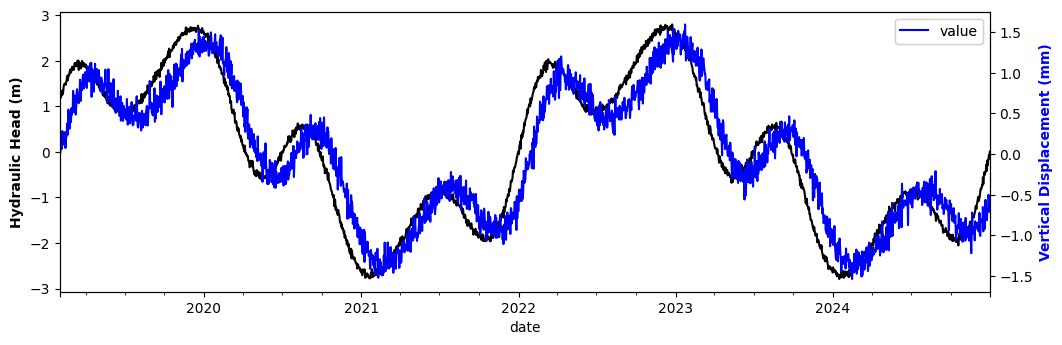

In [140]:
gwl_array = synthetic_daily_signal(
    start_date="2019-01-01",
    end_date="2024-12-31",
    linear_slope=0,
    amplitude_list=[2, 1, 0.2],
    period_list=[3, 0.75, 0.5],
    variance=0.05,
)
deformation_arr = synthetic_daily_signal(
    start_date="2019-1-01",
    end_date="2024-12-31",
    linear_slope=0,
    amplitude_list=[1, 0.5, 0.1],
    period_list=[3, 0.75, 0.5],
    variance=0.1,
)

deformation_arr = deformation_arr/1000
deformation_arr = deformation_arr.shift(30)
deformation_arr = deformation_arr.dropna()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)


gwl_array.plot(ax=ax1, color='black')
ax1.set_ylabel("Hydraulic Head (m)", color="black", fontweight='bold')

ax2 = ax1.twinx()
(deformation_arr*1000).plot(ax=ax2, color='blue')
ax2.set_ylabel("Vertical Displacement (mm)", color="blue", fontweight='bold')

Calculating hydraulic head...
Calculating strain...
Identifying elastic and inelastic behavior...
Estimated Elastic Storage Slope: 0.000470
Generating visualizations...


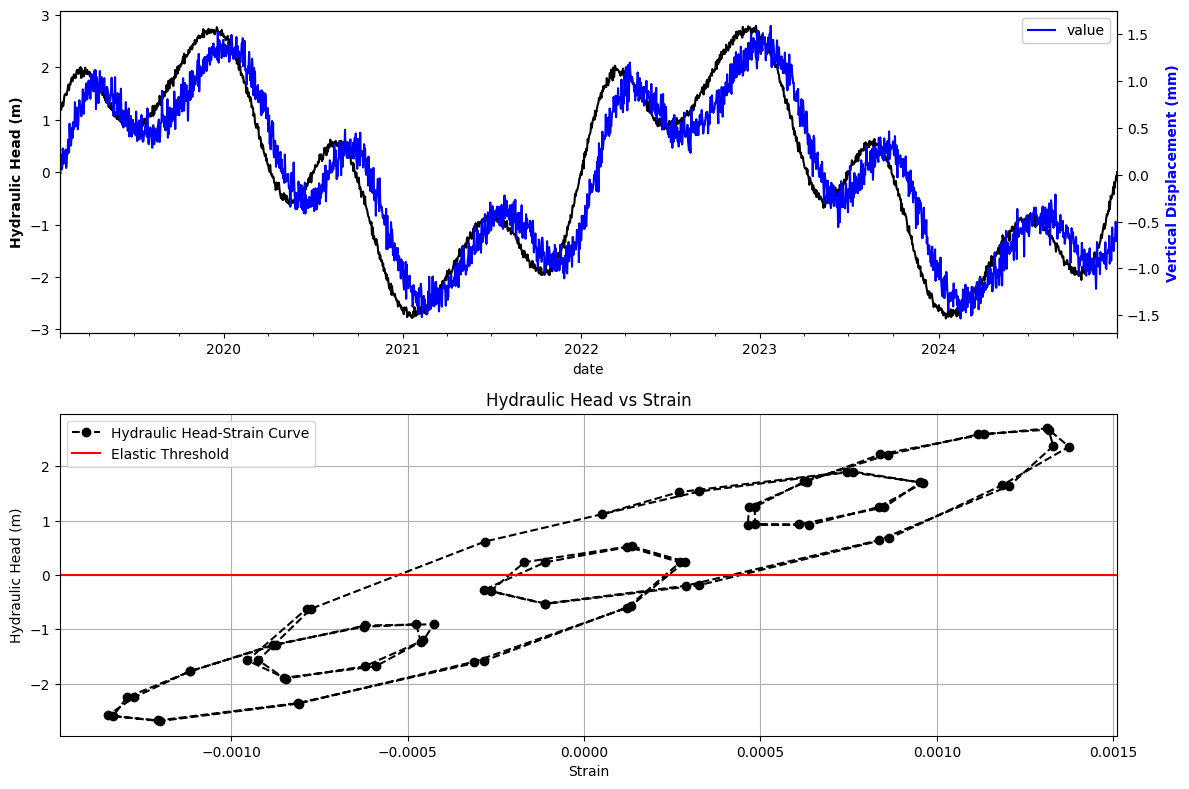

Workflow completed successfully.


In [143]:
mutual_index = gwl_array.index.intersection(deformation_arr.index)
data = pd.DataFrame(data=None, index=mutual_index)
data['GWL'] = data.index.map(gwl_array['value'])
data['SUB'] = data.index.map(deformation_arr['value'])
data = data.reset_index()

# -------------------------------------------------
# Main Workflow
# -------------------------------------------------

# Load the input data
data_file = 'GWL_SUB_table.csv'  # Update the file path
output_file = 'stress_strain_output.csv'
# data = pd.read_csv(data_file)

# Ensure correct column names
# data.columns = ['date', 'GWL', 'SUB']  # GWL: groundwater level; SUB: vertical displacement
data['date'] = pd.to_datetime(data['date'])

data = data.resample('M', on='date').mean()

# Assumed Parameters
initial_thickness = 1.0   # m, initial soil layer thickness

# Step 1: Calculate Hydraulic Head
print("Calculating hydraulic head...")
data['hydraulic_head'] = data['GWL']  # Assuming GWL directly represents hydraulic head

# Step 2: Calculate Strain
print("Calculating strain...")
data['strain'] = calculate_strain(data['SUB'], initial_thickness)

# Step 3: Identify Safe Hydraulic Head
print("Identifying elastic and inelastic behavior...")
critical_slope = identify_safe_gwl(data['hydraulic_head'], data['strain'])

# Step 4: Save Processed Data
# data.to_csv(output_file, index=False)
# print(f"Processed data saved to {output_file}")

# Step 5: Visualization
print("Generating visualizations...")

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)


gwl_array.plot(ax=ax1, color='black')
ax1.set_ylabel("Hydraulic Head (m)", color="black", fontweight='bold')

ax2 = ax1.twinx()
(deformation_arr*1000).plot(ax=ax2, color='blue')
ax2.set_ylabel("Vertical Displacement (mm)", color="blue", fontweight='bold')


ax3 = fig.add_subplot(212)
# Hydraulic Head-Strain Curve
ax3.plot(data['strain'], data['hydraulic_head'], 'o--', color='black', label='Hydraulic Head-Strain Curve')
ax3.axhline(critical_slope, color='r', linestyle='-', label='Elastic Threshold')
ax3.set_xlabel('Strain')
ax3.set_ylabel('Hydraulic Head (m)')
ax3.set_title('Hydraulic Head vs Strain')
ax3.legend()
ax3.grid(True)

fig.tight_layout()
plt.show()

# -------------------------------------------------
# End of Workflow
# -------------------------------------------------
print("Workflow completed successfully.")
